In [1]:
%matplotlib inline
import numpy
numpy.random.seed(0)

In [2]:
def get_dataset(n=250):
    """ Creates a simple 1D dataset.
    """

    numpy.random.seed(0)
    
    X = numpy.linspace(0, 3*numpy.pi, n)
    y = 0.5*numpy.sin(X) + numpy.random.normal(0, 0.1, n)
    
    return X, y

In [3]:
class LeastSquaresRegression():
    
    def __init__(self, lam=1.0, kernel="rbf", gamma=1.0, r=None, random_state=0):
        """ Instantiates the regression model.
        
        Parameters
        ----------
        lam : float, default 1.0
            The regularization parameter lambda
        kernel : string, default 'rbf'
            The kernel to be used
        gamma : float, default 1.0
            The kernel width gamma for the RBF kernel
        r : int or None, default None
            If None, then use all the training instances
            to represent the model. Otherwise, only 
            r random training instances are used (1 <= r <= n).
        random_state : int, default 0
            The random state (seed) to be used.
        """
        
        self.lam = lam
        self.kernel = kernel
        self.gamma = gamma
        self.r = r
        self.random_state = random_state

    def get_params(self, deep=True):
        """ Returns the parameters of the model
        """
        
        return {"lam": self.lam, 
                "kernel": self.kernel, 
                "gamma": self.gamma, 
                "r": self.r,
                "random_state": self.random_state}

    def set_params(self, **parameters):
        """ Sets the parameters of the model
        """        
        
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
            
        return self
    
    def fit(self, X, y):
        """
        Fits the regression model.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        y : Array of shape [n_samples, 1]
        """   
        
        numpy.random.seed(self.random_state)
        
        # make sure that we have numpy arrays; also
        # reshape the array X to ensure that we have
        # a multidimensional numpy array (ndarray);
        # for y, we want to have a column vector
        X = numpy.array(X).reshape((X.shape[0], -1))
        y = numpy.array(y).reshape((len(y), 1))

        self._Xtrain = X
        self._ytrain = y
        
        if self.r is None:
        
            km = self._compute_kernel_matrix(self._Xtrain, self._Xtrain)
            
            shifted_km = km + len(self._ytrain) * self.lam * numpy.identity(len(self._Xtrain))
            
            # NOT RECOMMENDED
            #self._c = numpy.dot(numpy.linalg.inv(shifted_km), self._ytrain)     
            self._c = numpy.linalg.solve(shifted_km, self._ytrain)
            
        else:

            assert self.r >= 1
            assert self.r <= X.shape[0]
            
            rsub = sorted(numpy.random.choice(X.shape[0], self.r, replace=False))
            
            self._Xtrain_sub = self._Xtrain[rsub]    
            
            kr = self._compute_kernel_matrix(self._Xtrain_sub, self._Xtrain)
            krr = self._compute_kernel_matrix(self._Xtrain_sub, self._Xtrain_sub)
            
            km = numpy.dot(kr, kr.T)
            km = km + len(self._ytrain) * self.lam * krr
            
            right = numpy.dot(kr, self._ytrain)
            
            # NOT RECOMMENDED!
            #self._c = numpy.dot(numpy.linalg.inv(km), right)
            
            self._c = numpy.linalg.solve(km, right)

        return self
     
        
    def predict(self, X):
        """
        Computes predictions for a new set of points.

        Parameters
        ----------
        X : Array of shape [n_samples, n_features]

        Returns
        -------
        predictions : Array of shape [n_samples, 1]
        """           
        
        # make sure that we have numpy arrays; also
        # reshape the array X to ensure that we have
        # a multidimensional numpy array (ndarray)
        X = numpy.array(X).reshape((X.shape[0], -1))

        if self.r is None:
            
            km = self._compute_kernel_matrix(X, self._Xtrain)
            preds = numpy.dot(km, self._c)
            
        else:
            
            km = self._compute_kernel_matrix(X, self._Xtrain_sub)
            preds = numpy.dot(km, self._c)
    
        return preds
            
    def _compute_kernel_matrix(self, X1, X2):
        """ Computes the kernel matrix
        """
        
        if self.kernel == "rbf":
            
            km = numpy.empty((X1.shape[0], X2.shape[0]), dtype=numpy.float64)
            
            for i in range(X1.shape[0]):
                for j in range(X2.shape[0]):
                    diff = X1[i] - X2[j]
                    tmp = numpy.dot(diff, diff)
                    km[i,j] = numpy.exp(- self.gamma * tmp)
                    

            return km
        
        elif self.kernel == "fast_rbf":
            
            norms1 = []
            for i in range(X1.shape[0]):
                norms1.append(numpy.dot(X1[i], X1[i].T))
            norms1 = numpy.array(norms1).reshape((len(norms1),-1))
            norms1 = norms1 * numpy.ones((1, X2.shape[0]), dtype=numpy.float64)
                        
            norms2 = []
            for j in range(X2.shape[0]):
                norms2.append(numpy.dot(X2[j], X2[j].T))
            norms2 = numpy.array(norms2).reshape((len(norms2), -1))
            norms2 = numpy.ones((X1.shape[0], 1), dtype=numpy.float64) * norms2.T
            km = norms1 + norms2 - 2*numpy.dot(X1, X2.T)
            
            km = -self.gamma * km
            km = numpy.exp(km)
            
            return km
            
        else:
            
            raise Exception("Unknown kernel: {}".format(self.kernel))


For demonstration purposes: Let's generate some toy data to illustrate the effect of the different parameters.

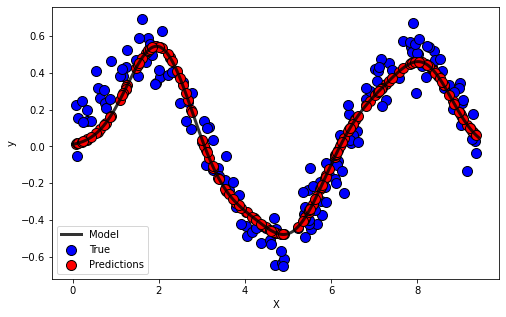

In [15]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X, y = get_dataset(n=500)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

plt.figure(figsize=(8,5))

model = LeastSquaresRegression(kernel="fast_rbf", lam=0.01, gamma=1, r=8)
model.fit(X_train, y_train)
preds = model.predict(X_test)

# plot test points and predictions
plt.scatter(X_test, y_test, s=100, c="b", edgecolor="k", linewidths=1, label="True")
plt.scatter(X_test, preds, s=100, c="r", edgecolor="k", linewidths=1, label="Predictions")

# plot model
x = numpy.linspace(X.min(), X.max(), 500)
plt.plot(x, model.predict(x), "-k", alpha=0.8, linewidth=3.0, label="Model")

plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
    
plt.show()